In [1]:
!pip install -r C:\Users\ezrag\OneDrive\Documents\GitHub\spotify-listening-data\requirements.txt

  Using cached noise-1.2.2.zip (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for noise: filename=noise-1.2.2-cp313-cp313-win_amd64.whl size=31959 sha256=9c96ff2d2195fca22c860b0d2ceaa6b57e44baf9fb228e693130216b8d5247cb
  Stored in directory: c:\users\ezrag\appdata\local\pip\cache\wheels\6a\4c\99\fe9adf3dca70780d28cf2e24e63a11fee02bdbe5d9931d3c38
Successfully built noise


In [6]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
SPOTIFY_CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

In [2]:
# Import necessary libraries
import pandas as pd
import json
import os
import random
from datetime import datetime, timedelta
from dotenv import load_dotenv
import threading
import queue
import requests
import time

In [6]:
# Function to get user ID from input
def get_user_id():
    user_id = input("Enter the user's ID: ").lower()
    return user_id


In [4]:
# Function to get the number of data chunks from input
def get_num_chunks():
    num_chunks = int(input("Enter the number of chunks: "))
    return num_chunks

In [7]:
# Function to read and process data from multiple JSON files
def read_and_process_data(user_id, num_chunks, base_path='wrapped_files/'):
    all_data = []
    
    for i in range(num_chunks):
        json_file = os.path.join(base_path, f'{user_id}_music_{i}.json')
        print(f"Checking for file: {json_file}")
        
        if not os.path.exists(json_file):
            print(f"File not found: {json_file}")
            continue
        
        print(f"Reading data from {json_file}")
        with open(json_file, 'r', encoding='utf-8') as file:
            data_list = json.load(file)
            all_data.extend(data_list)
    
    if not all_data:
        raise ValueError("No data files were found or all were empty.")
    
    df = pd.DataFrame(all_data)
    df['user_id'] = user_id
    df['endTime'] = pd.to_datetime(df['endTime'])
    
    print(f"Data read successfully for {len(df)} records.")
    return df


In [8]:
# Function to export data to a CSV file
def export_to_csv(df, user_id):
    csv_file = f'{user_id}_listening_data.csv'
    df.to_csv(csv_file, index=False)
    print(f"Data exported to {csv_file}")


In [9]:
# Function to track and save unique songs to a CSV file
def track_unique_songs(df, unique_songs_file):
    unique_songs = df[['trackName', 'artistName']].drop_duplicates()
    print(f"Tracking {len(unique_songs)} unique songs.")
    
    try:
        existing_songs = pd.read_csv(unique_songs_file)
        updated_songs = pd.concat([existing_songs, unique_songs]).drop_duplicates()
        print(f"Existing unique songs loaded, total unique songs now {len(updated_songs)}.")
    except FileNotFoundError:
        updated_songs = unique_songs
        print("Unique songs file not found. Creating a new one.")
    
    updated_songs.to_csv(unique_songs_file, index=False)
    print(f"Unique songs tracked and saved to {unique_songs_file}.")


In [10]:
# Function to get Spotify access token using client credentials
def get_spotify_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })
    
    # Parse the authentication response and extract access token
    auth_response_data = auth_response.json()
    return auth_response_data['access_token']

In [11]:
# Function to get song details from Spotify API using search query
def get_song_details(artist_name, track_name, access_token):
    search_url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'q': f'artist:{artist_name} track:{track_name}',
        'type': 'track',
        'limit': 1
    }
    
    # Send request to Spotify API to search for the track
    response = requests.get(search_url, headers=headers, params=params)
    response_data = response.json()
    
    if response_data['tracks']['items']:
        track_info = response_data['tracks']['items'][0]
        song_details = {
            'spotify_id': track_info['id'],
            'album': track_info['album']['name'],
            'release_date': track_info['album']['release_date'],
            'popularity': track_info['popularity'],
            'duration_ms': track_info['duration_ms'],
            'track_number': track_info['track_number'],
            'album_artwork': track_info['album']['images'][0]['url'] if track_info['album']['images'] else None,
            'external_urls': track_info['external_urls']['spotify'],
            'artists_involved': ", ".join(artist['name'] for artist in track_info['artists'])
        }
        return song_details
    else:
        return None

In [12]:
# Worker function to process each song in the queue
def worker_thread(queue, unique_songs, access_token, export_interval, lock, start_time):
    while not queue.empty():
        index, row = queue.get()
        if pd.notna(row['spotify_id']):
            print(f"Skipping already updated song at index {index}.")
            queue.task_done()
            continue
        
        artist_name = row['artistName']
        track_name = row['trackName']
        song_details = get_song_details(artist_name, track_name, access_token)
        
        if song_details:
            with lock:
                unique_songs.at[index, 'spotify_id'] = song_details['spotify_id']
                unique_songs.at[index, 'album'] = song_details['album']
                unique_songs.at[index, 'release_date'] = song_details['release_date']
                unique_songs.at[index, 'popularity'] = song_details['popularity']
                unique_songs.at[index, 'duration_ms'] = song_details['duration_ms']
                unique_songs.at[index, 'track_number'] = song_details['track_number']
                unique_songs.at[index, 'album_artwork'] = song_details['album_artwork']
                unique_songs.at[index, 'external_urls'] = song_details['external_urls']
                unique_songs.at[index, 'artists_involved'] = song_details['artists_involved']
        
        if (index + 1) % export_interval == 0:
            with lock:
                print(f"Exporting data at index {index}. Elapsed time: {time.time() - start_time:.2f} seconds.")
                unique_songs.to_csv(unique_songs_file, index=False)
        
        queue.task_done()
        print(f"Processed index {index}")

In [48]:
# Main function to update unique songs table with Spotify info using threading
def update_unique_songs(unique_songs_file='unique_songs.csv', export_interval=50):
    # Load unique songs data from CSV file
    unique_songs = pd.read_csv(unique_songs_file)
    
    # Check if the columns already exist, if not, create them
    if 'spotify_id' not in unique_songs.columns:
        unique_songs['spotify_id'] = None
    if 'album' not in unique_songs.columns:
        unique_songs['album'] = None
    if 'release_date' not in unique_songs.columns:
        unique_songs['popularity'] = None
    if 'duration_ms' not in unique_songs.columns:
        unique_songs['duration_ms'] = None
    if 'track_number' not in unique_songs.columns:
        unique_songs['track_number'] = None
    if 'album_artwork' not in unique_songs.columns:
        unique_songs['album_artwork'] = None
    if 'external_urls' not in unique_songs.columns:
        unique_songs['external_urls'] = None
    if 'artists_involved' not in unique_songs.columns:
        unique_songs['artists_involved'] = None

    # Get Spotify access token
    access_token = get_spotify_access_token(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET)
    
    # Create a queue and add songs to be processed
    q = queue.Queue()
    for index, row in unique_songs.iterrows():
        q.put((index, row))

    # Create a lock for thread-safe operations
    lock = threading.Lock()
    start_time = time.time()
    threads = []
    for _ in range(10):  # Adjust number of threads as needed
        thread = threading.Thread(target=worker_thread, args=(q, unique_songs, access_token, export_interval, lock, start_time))
        thread.start()
        threads.append(thread)
    
    # Wait for all threads to complete
    for thread in threads:
        thread.join()
    
    # Final export
    print(f"Final export. Total time taken: {time.time() - start_time:.2f} seconds.")
    unique_songs.to_csv(unique_songs_file, index=False)
    print(f"Unique songs table updated with Spotify info and saved to {unique_songs_file}.")


In [13]:
# Function to fill in song info from unique songs database
def fill_song_info(listening_data, unique_songs):
    # Merge listening data with unique songs data on 'artistName' and 'trackName'
    filled_data = pd.merge(listening_data, unique_songs, on=['artistName', 'trackName'], how='left')
    return filled_data

In [14]:
# Function to read processed listening data
def read_processed_data(user_id):
    csv_file = f'{user_id}_listening_data.csv'  # Example file path, adjust as needed
    listening_data = pd.read_csv(csv_file)
    return listening_data

In [15]:
# Function to export filled listening data to a CSV file
def export_filled_data(filled_data, user_id):
    filled_csv_file = f'{user_id}_filled_listening_data.csv'
    filled_data.to_csv(filled_csv_file, index=False)
    print(f"Filled listening data exported to {filled_csv_file}")

In [18]:
# Execute the main steps to read data, export to CSV, and track unique songs
user_id = get_user_id()
num_chunks = get_num_chunks()
base_path = '../wrapped_files/'  # Adjusting the relative path based on the notebook location
unique_songs_file = 'unique_songs.csv'

try:
    df = read_and_process_data(user_id, num_chunks, base_path)
    export_to_csv(df, user_id)
    track_unique_songs(df, unique_songs_file)

    print("Data processing complete!")
except ValueError as e:
    print(e)

Checking for file: ../wrapped_files/samfa_music_0.json
Reading data from ../wrapped_files/samfa_music_0.json
Data read successfully for 6228 records.
Data exported to samfa_listening_data.csv
Tracking 3186 unique songs.
Existing unique songs loaded, total unique songs now 7485.
Unique songs tracked and saved to unique_songs.csv.
Data processing complete!


In [45]:
import requests
# Execute the function to update unique songs table with Spotify info
update_unique_songs('unique_songs.csv')

Skipping already updated song at index 0.
Skipping already updated song at index 1.
Skipping already updated song at index 2.
Skipping already updated song at index 3.
Skipping already updated song at index 4.
Skipping already updated song at index 5.
Skipping already updated song at index 6.
Skipping already updated song at index 7.
Skipping already updated song at index 8.
Skipping already updated song at index 9.
Skipping already updated song at index 10.
Skipping already updated song at index 11.
Skipping already updated song at index 12.
Skipping already updated song at index 13.
Skipping already updated song at index 14.
Skipping already updated song at index 15.
Skipping already updated song at index 16.
Skipping already updated song at index 17.
Skipping already updated song at index 18.
Skipping already updated song at index 19.
Skipping already updated song at index 20.
Skipping already updated song at index 21.
Skipping already updated song at index 22.
Skipping already upda

In [49]:
import pandas as pd

# Load the unique songs database
unique_songs_file = 'unique_songs.csv'
unique_songs = pd.read_csv(unique_songs_file)

# Sort the database by artistName
sorted_unique_songs = unique_songs.sort_values(by='artistName')

# Save the sorted database to a new CSV file
sorted_unique_songs_file = 'sorted_unique_songs.csv'
sorted_unique_songs.to_csv(sorted_unique_songs_file, index=False)

print(f"Sorted unique songs database saved to {sorted_unique_songs_file}.")

Sorted unique songs database saved to sorted_unique_songs.csv.


In [74]:
# Load unique songs data
unique_songs_file = 'unique_songs.csv'
unique_songs = pd.read_csv(unique_songs_file)

# Get user ID and read processed listening data
user_id = get_user_id()
try:
    listening_data = read_processed_data(user_id)
    
    # Fill in song info from unique songs database
    filled_listening_data = fill_song_info(listening_data, unique_songs)
    
    # Export the filled listening data to a new CSV file
    export_filled_data(filled_listening_data, user_id)

    print("Data processing complete!")
except FileNotFoundError:
    print(f"Processed data file not found for user ID: {user_id}")


Filled listening data exported to ezra_filled_listening_data.csv
Data processing complete!


# Analysis of Filled Listening Data

1. Imports and Setup

In [8]:
import os
import pandas as pd
import requests
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import random
import noise

# Ensure all necessary packages are installed
# If not, you can install them using pip
# pip install pandas requests matplotlib Pillow noise

2. Color Generation Functions

In [9]:
# Function to generate a random color
def generate_random_color():
    color = (random.randint(100, 255), random.randint(100, 255), random.randint(100, 255))
    print(f"Generated random color: {color}")
    return color

# Function to generate a color close to a given color
def generate_similar_color(color, variance=50):
    r = min(max(color[0] + random.randint(-variance, variance), 0), 255)
    g = min(max(color[1] + random.randint(-variance, variance), 0), 255)
    b = min(max(color[2] + random.randint(-variance, variance), 0), 255)
    similar_color = (r, g, b)
    print(f"Generated color similar to {color}: {similar_color}")
    return similar_color


3. Abstract Background Generation

In [33]:
# Function to generate an abstract background with dynamic colors
def generate_abstract_background(width=1080, height=1920):
    print(f"Generating abstract background of size {width}x{height}")
    start_color = generate_random_color()
    end_color = generate_similar_color(start_color)
    
    # Create a gradient based on the generated colors
    gradient = np.linspace(start_color, end_color, width).astype(int)
    gradient_cmap = plt.cm.colors.ListedColormap(gradient / 255.0)

    x = np.linspace(-5, 5, width)
    y = np.linspace(-5, 5, height)
    X, Y = np.meshgrid(x, y)
    
    Z = np.sin(X**2 + Y**2) * np.cos(Y**2 - X**2)
    
    plt.figure(figsize=(width / 100, height / 100), dpi=100)
    plt.imshow(Z, cmap=gradient_cmap, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('abstract_background.png', bbox_inches='tight', pad_inches=0)
    plt.close()

    background = Image.open('abstract_background.png')
    background = background.resize((width, height))
    print("Abstract background generated and saved as 'abstract_background.png'")
    return background




# Function to generate Perlin noise
def generate_perlin_noise(width, height, scale=100, seed=random.randint(0,500)):
    print(f"Generating Perlin noise of size {width}x{height} with scale {scale} and seed {seed}")
    shape = (width, height)
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i / scale, j / scale, octaves=6, persistence=0.5, lacunarity=2.0, repeatx=1024, repeaty=1024, base=seed)
    
    norm_world = (world - np.min(world)) / (np.max(world) - np.min(world))
    print("Perlin noise generated")
    return norm_world

# Function to generate an abstract background with Perlin noise
def generate_abstract_background_with_noise(width=1080, height=1920):
    print(f"Generating abstract background with Perlin noise of size {width}x{height}")
    noise_pattern = generate_perlin_noise(width, height)
    
    start_color = generate_random_color()
    end_color = generate_similar_color(start_color)
    gradient = np.linspace(start_color, end_color, width).astype(int)
    gradient_cmap = plt.cm.colors.ListedColormap(gradient / 255.0)

    plt.figure(figsize=(width / 100, height / 100), dpi=100)
    plt.imshow(noise_pattern, cmap=gradient_cmap, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('abstract_background_with_noise.png', bbox_inches='tight', pad_inches=0)
    plt.close()

    background = Image.open('abstract_background_with_noise.png')
    background = background.resize((width, height))
    print("Abstract background with Perlin noise generated and saved as 'abstract_background_with_noise.png'")
    return background





4. Text Drawing Function

In [11]:
# Function to draw wrapped text
def draw_wrapped_text(draw, text, position, font, max_width, fill):
    print(f"Drawing wrapped text: {text}")
    lines = []
    words = text.split()
    while words:
        line = ''
        while words and font.getbbox(line + words[0])[2] <= max_width:
            line += (words.pop(0) + ' ')
        lines.append(line)
    y_offset = position[1]
    for line in lines:
        draw.text((position[0], y_offset), line, font=font, fill=fill)
        y_offset += font.getbbox(line)[3]  # Use getbbox for line height
    print(f"Wrapped text drawn at position {position}")
    return y_offset


5. Layout Image Creation

In [12]:
# Function to create and save layout images
def create_layout_image(title, top_artists, album_art, file_path, user_id, background):
    print(f"Creating layout image: {file_path}")
    width, height = background.size
    image = background.copy()
    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype("arial.ttf", 40)
    title_font = ImageFont.truetype("arial.ttf", 60)
    user_id_font = ImageFont.truetype("arial.ttf", 30)
    
    draw.text((width / 2, 50), title, font=title_font, fill="white", anchor="mm")
    draw.text((width / 2, 150), f"User: {user_id}", font=user_id_font, fill="white", anchor="mm")

    y_offset = 250
    x_offset = 50

    for rank, (artist, value) in enumerate(top_artists.items(), start=1):
        if artist not in album_art:
            continue
        
        art = Image.open(album_art[artist]).resize((100, 100))
        image.paste(art, (x_offset, y_offset))
        
        text = f"{rank}. {artist}: {value}"
        draw_wrapped_text(draw, text, (x_offset + 120, y_offset), font, max_width=width - x_offset - 120, fill="white")
        y_offset += 120

    image.save(file_path)
    print(f"Layout image saved to {file_path}")


6. Album Art Download

In [ ]:
# Function to fetch and download all popular album art for each artist
def download_all_album_art(df, top_artists):
    print("Downloading album art for top artists")
    album_art = {}
    for artist in top_artists:
        artist_data = df[df['artistName'] == artist]
        if artist_data.empty:
            continue
        
        art_urls = artist_data['album_artwork'].value_counts().index.tolist()
        downloaded = False
        for art_url in art_urls:
            try:
                response = requests.get(art_url)
                img = Image.open(BytesIO(response.content))
                
                img_path = os.path.join("albums", f'{artist}_album_art.jpg')
                img.save(img_path)
                
                album_art[artist] = img_path
                downloaded = True
                print(f"Downloaded album art for {artist}: {img_path}")
                break
            except Exception as e:
                print(f"Error downloading {art_url} for {artist}: {e}")
                continue
        if not downloaded:
            print(f"Could not download album art for {artist}")
    return album_art

7. Data Processing Functions

In [13]:
# Function to calculate percentage listened for each track
def calculate_percentage_listened(df):
    print("Calculating percentage listened for each track")
    df['percentage_listened'] = df['msPlayed'] / df['duration_ms']
    print("Percentage listened calculated")
    return df

# Function to calculate top listened-to artists by listening time
def top_artists_by_time(df, top_n=10):
    print(f"Calculating top {top_n} artists by listening time")
    artist_time = df.groupby('artistName')['msPlayed'].sum().sort_values(ascending=False).head(top_n)
    artist_time_seconds = artist_time / 1000  # Convert milliseconds to seconds
    print("Top artists by listening time calculated")
    return artist_time_seconds

# Function to calculate top listened-to artists by count
def top_artists_by_count(df, top_n=10):
    print(f"Calculating top {top_n} artists by count")
    artist_count = df['artistName'].value_counts().head(top_n)
    print("Top artists by count calculated")
    return artist_count

# Function to calculate top listened-to artists by weighted listening time
def top_artists_by_weighted_time(df, top_n=10):
    print(f"Calculating top {top_n} artists by weighted listening time")
    artist_weighted_time = df.groupby('artistName')['percentage_listened'].sum().sort_values(ascending=False).head(top_n)
    print("Top artists by weighted listening time calculated")
    return artist_weighted_time

# Function to read filled listening data
def read_filled_listening_data(file_path):
    print(f"Reading filled listening data from {file_path}")
    df = pd.read_csv(file_path)
    print("Filled listening data read successfully")
    return df


In [29]:
def main():
    # Generate Instagram story-sized abstract background with Perlin noise and custom colormap
    background = generate_abstract_background_with_noise(1080, 1920)

    # Load unique songs data
    unique_songs_file = 'unique_songs.csv'
    unique_songs = pd.read_csv(unique_songs_file)

    # Get user ID and construct the file path
    user_name = get_user_id()
    file_path = f'{user_name}_filled_listening_data.csv'

    try:
        # Read the filled listening data
        filled_listening_data = read_filled_listening_data(file_path)
        
        # Calculate percentage listened for each track
        filled_listening_data = calculate_percentage_listened(filled_listening_data)
        
        # Calculate top listened-to artists
        top_artists_count = top_artists_by_count(filled_listening_data).head(5)
        top_artists_time = top_artists_by_time(filled_listening_data).head(5)
        top_artists_weighted_time = top_artists_by_weighted_time(filled_listening_data).head(5)
        
        # Combine all top artists to ensure all album art is downloaded
        all_top_artists = top_artists_count.index.union(top_artists_time.index).union(top_artists_weighted_time.index)
        
        # Download the most common album art for each artist
        album_art = download_all_album_art(filled_listening_data, all_top_artists)
        
        # Create layout images with user ID in the file name and abstract background
        create_layout_image("Top Artists by Count", top_artists_count, album_art, f"{user_name}_spotify_wrapped_top_artists_count.png", user_name, background)
        create_layout_image("Top Artists by Listening Time (minutes)", {k: v / 60 for k, v in top_artists_time.items()}, album_art, f"{user_name}_spotify_wrapped_top_artists_time.png", user_name, background)
        create_layout_image("Top Artists by Weighted Listening Time", top_artists_weighted_time, album_art, f"{user_name}_spotify_wrapped_top_artists_weighted_time.png", user_name, background)
        
        print("Data processing and layout creation complete!")
    except FileNotFoundError:
        print(f"File not found: {file_path}")

# Run the main function
if __name__ == '__main__':
    main()


Generating abstract background with Perlin noise of size 1080x1920
Generating Perlin noise of size 1080x1920 with scale 100 and seed 42
Perlin noise generated
Generated random color: (243, 202, 225)
Generated color similar to (243, 202, 225): (212, 182, 219)
Abstract background with Perlin noise generated and saved as 'abstract_background_with_noise.png'
Reading filled listening data from ezra_filled_listening_data.csv
Filled listening data read successfully
Calculating percentage listened for each track
Percentage listened calculated
Calculating top 10 artists by count
Top artists by count calculated
Calculating top 10 artists by listening time
Top artists by listening time calculated
Calculating top 10 artists by weighted listening time
Top artists by weighted listening time calculated
Creating layout image: ezra_spotify_wrapped_top_artists_count.png
Drawing wrapped text: 1. Unknown Artist: 612
Wrapped text drawn at position (170, 250)
Drawing wrapped text: 2. Crazy Ex-Girlfriend Cas

Generating abstract background of size 1080x1920
Generated random color: (161, 253, 146)
Generated color similar to (161, 253, 146): (168, 255, 156)
Abstract background generated and saved as 'abstract_background.png'
Abstract background 1 saved as 'test/abstract_background_1.png'
Generating abstract background with Perlin noise of size 1080x1920
Generating Perlin noise of size 1080x1920 with scale 100 and seed 323
Perlin noise generated
Generated random color: (251, 142, 111)
Generated color similar to (251, 142, 111): (211, 127, 112)
Abstract background with Perlin noise generated and saved as 'abstract_background_with_noise.png'
Abstract background with Perlin noise 1 saved as 'test/abstract_background_with_noise_1.png'
Generating abstract background of size 1080x1920
Generated random color: (227, 192, 146)
Generated color similar to (227, 192, 146): (255, 160, 106)
Abstract background generated and saved as 'abstract_background.png'
Abstract background 2 saved as 'test/abstract_bac

KeyboardInterrupt: 

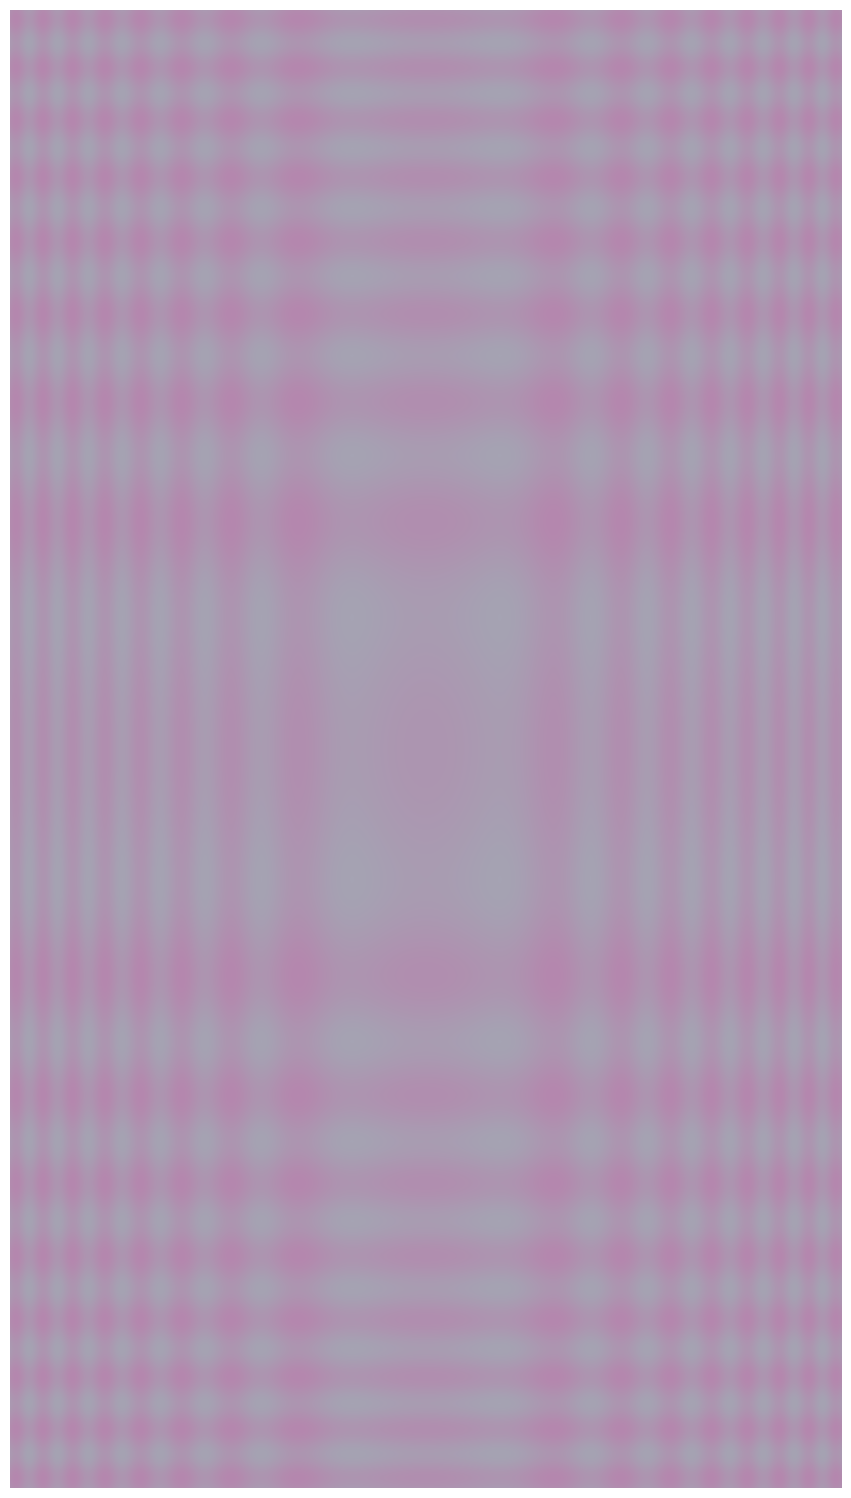

In [ ]:
import os

# Ensure the /test directory exists
os.makedirs('test', exist_ok=True)

# Function to generate multiple backgrounds
def generate_multiple_backgrounds(n=15):
    for i in range(n):
        # Generate abstract background
        background = generate_abstract_background(1080, 1920)
        background.save(f'test/abstract_background_{i+1}.png')
        print(f"Abstract background {i+1} saved as 'test/abstract_background_{i+1}.png'")
        
        # Generate abstract background with Perlin noise
        background_with_noise = generate_abstract_background_with_noise(1080, 1920)
        background_with_noise.save(f'test/abstract_background_with_noise_{i+1}.png')
        print(f"Abstract background with Perlin noise {i+1} saved as 'test/abstract_background_with_noise_{i+1}.png'")

# Run the function to generate 15 backgrounds
generate_multiple_backgrounds(15)


In [15]:
import unittest

class TestColorGeneration(unittest.TestCase):

    def test_generate_random_color(self):
        color = generate_random_color()
        self.assertIsInstance(color, tuple)
        self.assertEqual(len(color), 3)
        for channel in color:
            self.assertTrue(100 <= channel <= 255)

    def test_generate_similar_color(self):
        base_color = (150, 150, 150)
        similar_color = generate_similar_color(base_color)
        self.assertIsInstance(similar_color, tuple)
        self.assertEqual(len(similar_color), 3)
        for channel in similar_color:
            self.assertTrue(0 <= channel <= 255)

# Run tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestColorGeneration)
unittest.TextTestRunner().run(suite)


..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


Generated random color: (106, 198, 209)
Generated color similar to (150, 150, 150): (114, 161, 146)


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [19]:
import unittest
from PIL import Image

class TestAbstractBackgroundGeneration(unittest.TestCase):

    def test_generate_abstract_background(self):
        background = generate_abstract_background(100, 100)
        self.assertIsInstance(background, Image.Image)
        self.assertEqual(background.size, (100, 100))

    def test_generate_perlin_noise(self):
        noise = generate_perlin_noise(100, 100)
        self.assertIsInstance(noise, np.ndarray)
        self.assertEqual(noise.shape, (100, 100))

    def test_generate_abstract_background_with_noise(self):
        background = generate_abstract_background_with_noise(100, 100)
        self.assertIsInstance(background, Image.Image)
        self.assertEqual(background.size, (100, 100))

# Run tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestAbstractBackgroundGeneration)
unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 0.060s

OK


Generating abstract background of size 100x100
Generated random color: (159, 221, 231)
Generated color similar to (159, 221, 231): (198, 200, 244)
Abstract background generated and saved as 'abstract_background.png'
Generating abstract background with Perlin noise of size 100x100
Generating Perlin noise of size 100x100 with scale 100 and seed 42
Perlin noise generated
Abstract background with Perlin noise generated and saved as 'abstract_background_with_noise.png'
Generating Perlin noise of size 100x100 with scale 100 and seed 42
Perlin noise generated


<unittest.runner.TextTestResult run=3 errors=0 failures=0>